In [1]:
### Understanding the metric learning stage

import numpy as np
import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import scipy
import os
import torch

PATH_DATA = '../data/' # CHANGE THAT
PATH = '../codes/'
sys.path.insert(1,PATH)

import sys
sys.path.insert(1,PATH_DATA)

import matplotlib as mpl
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.preamble']=[r'\usepackage{euler}']
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams.update({'font.size': 22})
from matplotlib.ticker import MaxNLocator
vcol = ['mediumseagreen','crimson','steelblue','darkmagenta','burlywood','khaki','lightblue','darkseagreen','deepskyblue','forestgreen','gold','indianred','midnightblue','olive','orangered','orchid','red','steelblue']

import IAE_MLP_JAX_devl_Oct22 as iae

def normalize(X,opt=1,log=False):
    if log:
        Y = np.log10(X.T)
    else:
        Y = X.T
    if opt == 1:
        Y = Y/np.sum(abs(Y),axis=0)
    if opt == 2:
        Y = Y/np.sqrt(np.sum(Y**2,axis=0))
    if opt == 'inf':
        Y = 0.5*Y/np.max(Y,axis=0)
    return Y.T


<ipython-input-1-0790ceb9e244>:22: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble']=[r'\usepackage{euler}']
/Users/jbobin/opt/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/Users/jbobin/opt/anaconda3/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
### Generating the Data
RN_NAME = ["Co60","Ba133","Co57","Cs137"]

def read_spectrum(fname):
    spec = []
    for line in open(fname, 'r'):
        spec.append(float(line.rstrip()))
    return np.array(spec)

def GetSingleSpectrum(name=0,v=0):
    
    val = ["02","04","06","08","10","12","14","16","18","20","22","24","26","28","30"]
    spec = read_spectrum(PATH_DATA+"SPS_NaITl_"+RN_NAME[name]+"_STEEL"+val[v]+"mm.dat")

    spec = spec[10:1450]
    spec = spec*(spec > 1e-3*np.max(spec)) + 1e-3*np.max(spec)
    u = np.linspace(0,len(spec)-1,288,dtype='int') # not quite the best ... we should interpolate
    spec = spec[u]

    return spec/np.linalg.norm(spec,axis=0)

def GetSpectra(name=0):
    
    val = ["02","04","06","08","10","12","14","16","18","20","22","24","26","28","30"]
    spec = np.zeros((2999,len(val)))

    q = -1
    for r in val:
        q = q+1
        spec[:,q] = read_spectrum(PATH_DATA+"SPS_NaITl_"+RN_NAME[name]+"_STEEL"+r+"mm.dat")

    spec = spec[10:1450,:]
    spec = spec*(spec > 1e-3*np.max(spec)) + 1e-3*np.max(spec)
    u = np.linspace(0,len(spec)-1,288,dtype='int') # not quite the best ... we should interpolate
    spec = spec[u,:]

    return spec/np.linalg.norm(spec,axis=0)

### Get the spectra

Text(0, 0.5, 'Normalized signature')

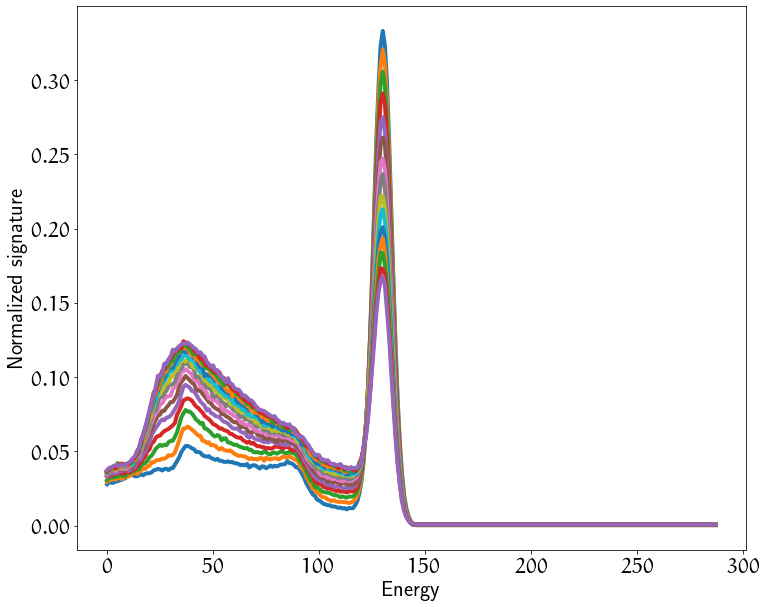

In [3]:
name = 3
spec =  GetSpectra(name=name).T
plt.figure(figsize=(12,10))
plt.plot(spec.T,lw=4)
plt.xlabel('Energy')
plt.ylabel('Normalized signature')

In [4]:
I = np.random.permutation(13)+1
I_train = np.concatenate((np.array([0,14]),I[0:8]))
I_test = I[8::]
X = normalize(spec[I_train],'inf')
AP = normalize(spec[[0,14]],'inf')  # Choosing the anchorpoints (here the extreme cases)

# Test training with JAX MLP

In [5]:
fname = 'IAE_Test_JAX_MLP' # name of the saved model

NL = 2  # number of layers
l = AP.shape[1]
NSizeIn = np.zeros((NL+1,2)) # number of hidden units per layer
NSizeIn[:,0] = [l,l,l]
NSizeIn[:,1] = [1,1,1]
NSizeOut = np.zeros((NL+1,2)) # number of channels per layer (in case of multivalued data for instance)
NSizeOut[:,0] = [l,l,l]
NSizeOut[:,1] = [1,1,1]

step_size = 1e-3 # learning rate
niter = 5000    # number of epochs
nneg_weights = False # if true, imposes the latent space code to be positive
simplex = True # if true, imposes the latent space code to belong to the simplex
noise_level = 1e-2 # adds noise at training stage
reg_parameter = 0.1 # regularisatio parameter

lfn = iae.IAE(fname=fname,AnchorPoints=AP[:,:,np.newaxis],NSizeIn=NSizeIn.astype('int'), NSizeOut=NSizeOut.astype('int'), 
                 simplex=simplex,reg_parameter=reg_parameter, noise_level=noise_level, nneg_weights=nneg_weights, step_size=step_size, niter=niter)

out = lfn.learning_stage(X[:,:,np.newaxis]) # Launches the training procedure


/Users/jbobin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jbobin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Testing the model on noisy data

Text(0, 0.5, 'Normalized signature')

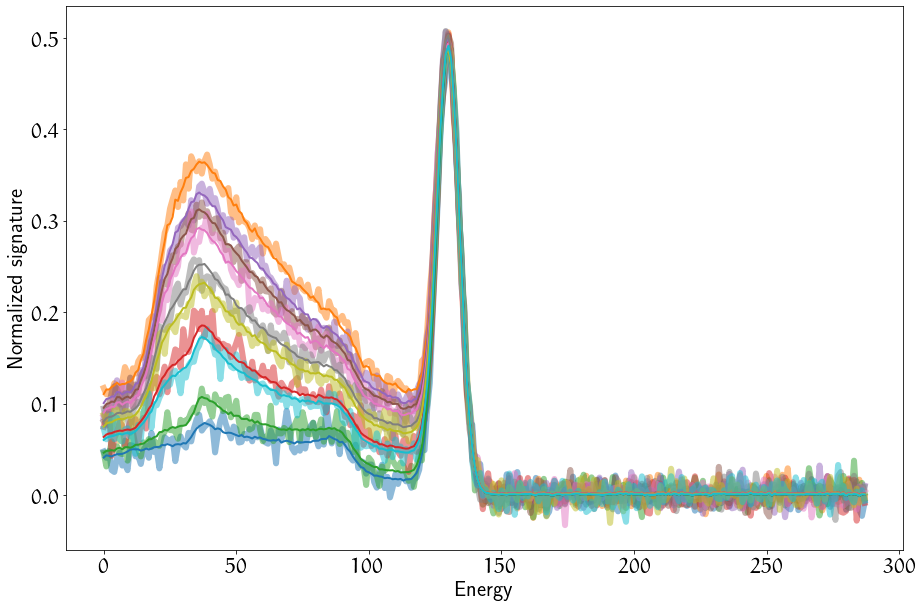

In [6]:
Xn = X + 0.01*np.random.randn(*X.shape) # Add noise to the data
rec = lfn.fast_interpolation(Xn[:,:,np.newaxis]) # simple projection onto the model manifold
xrec = rec["XRec"]
plt.figure(figsize=(15,10))
plt.plot(Xn[:,:].T,lw=6,alpha=0.5,label='Input')
plt.plot(xrec[:,:,0].T,lw=2,label='Recovered')
plt.xlabel('Energy')
plt.ylabel('Normalized signature')

### A more precise model manifold projection

In [7]:
rec = lfn.barycentric_span_projection(Xn[:,:,np.newaxis]) # simple projection onto the model manifold


Text(0, 0.5, 'Normalized signature')

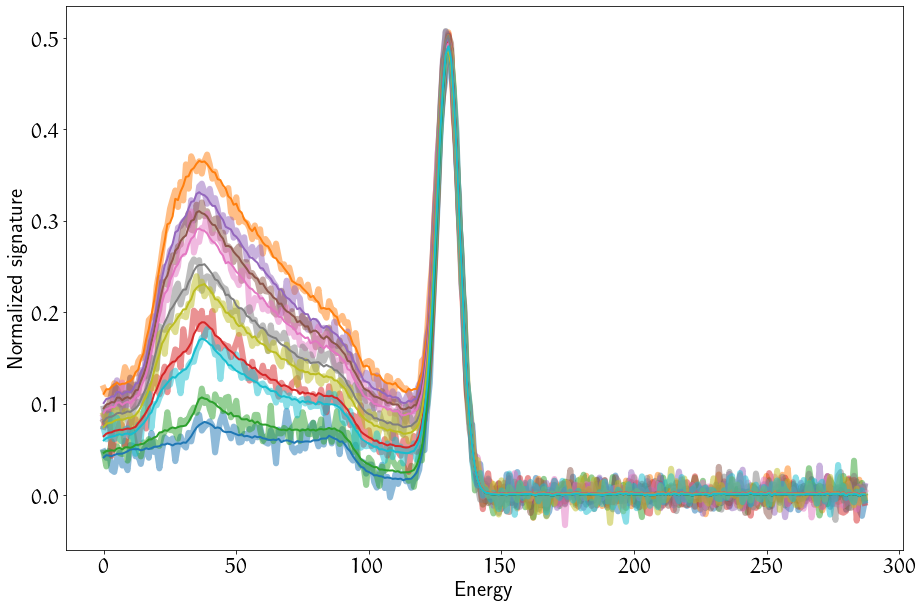

In [8]:
xrec = rec["XRec"]
plt.figure(figsize=(15,10))
plt.plot(Xn[:,:].T,lw=6,alpha=0.5,label='Input')
plt.plot(xrec[:,:,0].T,lw=2,label='Recovered')
plt.xlabel('Energy')
plt.ylabel('Normalized signature')

## Training the CNN-based IAE model

device USED:  cpu
NAdam


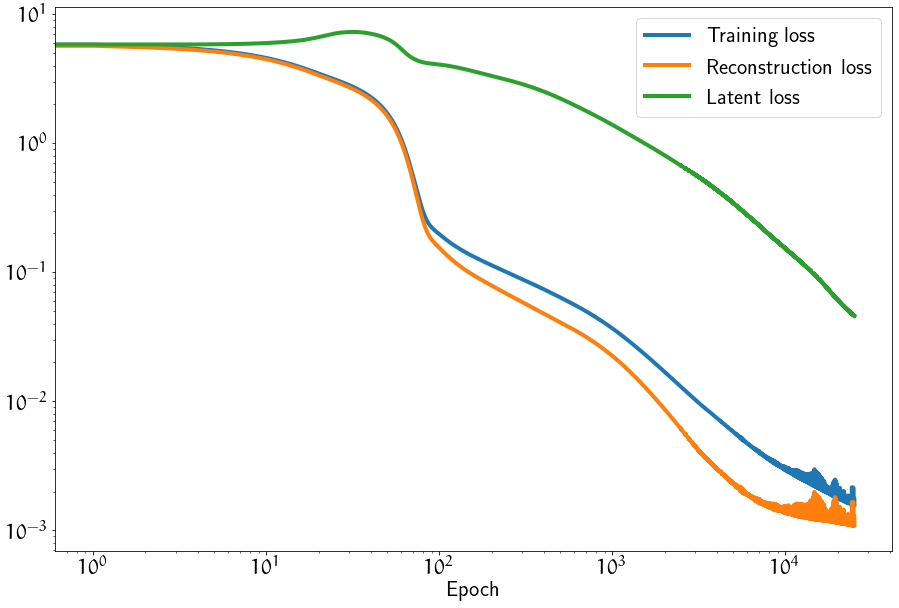

In [9]:
import IAE_CNN_TORCH_devl_Oct22 as iae_tc
fname = 'IAE_Test_TORCH_CNN' 

NL = 4
NSize = np.zeros((NL,3))
NSize[:,0] = [2,2,2,2]  # Filter size
NSize[:,2] = [1,2,1,2] # Stride
NSize[:,1] = [2,2,2,2] # NFilters
NSize = NSize.astype('int32')
rho_latcon = [0.1,0.01,0.01,0.001,0.001,0.0001,0.0001,0.0001]

step_size = 1e-3
niter = 25000
nneg_weights = False
simplex = True
reg_parameter = 1e-2

out=iae_tc.learning_stage(X[:,:,np.newaxis],AP[:,:,np.newaxis],PositiveWeights=nneg_weights,Xvalidation=None,batch_size=128,decay_epoch=2000,learning_rate=1e-3,reg_parameter=reg_parameter,epochs=niter,NSize=NSize,niter_sparse = 10,sparse_code = False,simplex = simplex,fname=fname,noise_level=None,display=True,verb=True)


In [10]:
Model = torch.load("IAE_Test_TORCH_CNN_fullmodel.pth")
Xn = X + 0.01*np.random.randn(*X.shape)
rec = Model.fast_interpolation(torch.as_tensor(Xn[:,:,np.newaxis].astype('float32')))["XRec"]


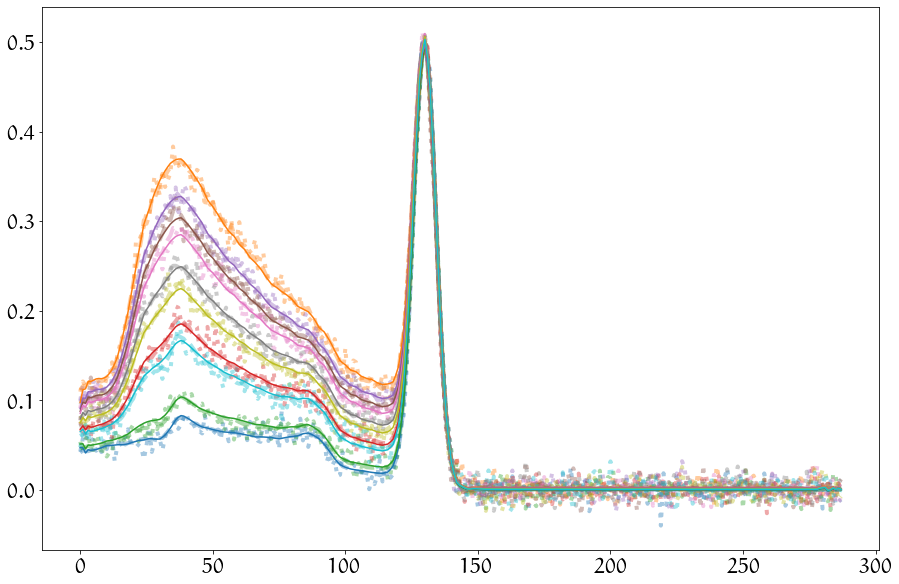

In [11]:
plt.figure(figsize=(15,10))
plt.plot(Xn.T,':',lw=4,alpha=0.4)
plt.plot(X.T,'--',lw=4,alpha=0.4)
plt.plot(rec[:,:,0].detach().numpy().T)

